<a href="https://colab.research.google.com/github/lauramaria99/SenalesMarcha/blob/main/Proyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Programa de Bioingeniería** 

**Bioseñales y Sistemas** 

**Proyecto 1** 




El presente trabajo pretende realizar un análisis de algunos datos extraidos a partir de una base de datos ya establecida, con el objetivo de visualizar el comportamiento de la marcha de algunos sujetos que padecen enfermedades neurodegenerativas. Este análisis se realiza usando herramenientas de la estadistica descriptiva y la implementación de pruebas de hipotesis sobre los índices de fluctuación dinamica y de magnitud relacionados con la variabilidad en la marcha de los sujetos en cuestión.    

# Extracción de datos

In [ ]:
#Se extrae la información de la base de datos dada.
!wget https://physionet.org/static/published-projects/gaitndd/gait-in-neurodegenerative-disease-database-1.0.0.zip
!unzip gait-in-neurodegenerative-disease-database-1.0.0.zip
!mv gait-in-neurodegenerative-disease-database-1.0.0 senales

--2020-10-17 13:29:58--  https://physionet.org/static/published-projects/gaitndd/gait-in-neurodegenerative-disease-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18788912 (18M) [application/zip]
Saving to: ‘gait-in-neurodegenerative-disease-database-1.0.0.zip’

gait-in-neurodegene 100%[===================>]  17.92M  11.7MB/s    in 1.5s    

2020-10-17 13:30:00 (11.7 MB/s) - ‘gait-in-neurodegenerative-disease-database-1.0.0.zip’ saved [18788912/18788912]

Archive:  gait-in-neurodegenerative-disease-database-1.0.0.zip
 extracting: gait-in-neurodegenerative-disease-database-1.0.0/control14.hea-  
 extracting: gait-in-neurodegenerative-disease-database-1.0.0/control5.hea-  
 extracting: gait-in-neurodegenerative-disease-database-1.0.0/park6.hea-  
 extracting: gait-in-neurodegenerative-disease-database-1.0.0/hunt13.rit  
 extracting: g

In [ ]:
!pip install wfdb #Se instala biblioteca para leer, escribir y procesar señales.

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 6.8MB 11.1MB/s 
     |████████████████████████████████| 163kB 32.8MB/s 
  Created wheel for wfdb: filename=wfdb-3.1.1-cp36-none-any.whl size=117828 sha256=185e3c9bf24e9f4d59f5121ecbf0615241fdecad4dd88361013a9bd75a51b170
  Stored in directory: /root/.cache/pip/wheels/bc/d0/c1/90538d266ccba2d1076fbc9970192c7ea1a09c99df3e65c69b
Successfully built wfdb


# Carga y visualización de datos

In [ ]:
#Se importan las librerias wfdb, numpy, matplotlib y pandas.
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings 
import glob #Se importa la libreria 'glob'.
warnings.filterwarnings("ignore") #Se ignoran las alertas para mejorar la visualización.

#Se leen los datos de la carpeta 'senales' y se extraen los archivos de series de tiempo para control1, als5, park11 y hunt10.
names = ['time','LSI','RSI','LSwI','RSwI','LSIp','RSIp','LStI','RStI','LStIp','RStIp','DSI','DSIp']
control = glob.glob('/content/senales/control*ts') #Se cargan los archivos correspondientes a los pacientes control.
als = glob.glob('/content/senales/als*ts') #Se cargan los archivos correspondientes a los pacientes con ELA.
hunt = glob.glob('/content/senales/hunt*ts') #Se cargan los archivos correspondientes a los pacientes con enfermedad de Huntington.
park = glob.glob('/content/senales/park*ts') #Se cargan los archivos correspondientes a los pacientes con Parkinson.

#Se leen los datos de un sujeto aleatorio por cada grupo de datos
control1 = pd.read_csv("/content/senales/control1.ts",sep='\t',names=names)
als6 = pd.read_csv("/content/senales/als6.ts",sep='\t',names=names) 
park11 = pd.read_csv("/content/senales/park11.ts",sep='\t',names=names)  
hunt10 = pd.read_csv("/content/senales/hunt10.ts",sep='\t',names=names) 

**Filtrado de las señales**

En el proceso de análisis de datos, el filtrado es un procedimiento de vital importancia puesto que permite la eliminación de datos atípicos de las muestras a procesar y en el caso de la marcha, es posible encontrar este tipo de datos debido a fallas en los sensores e instrumentos de medición y a la variaciones en la velocidad de la marcha en el momento de despegar avanzar o apoyar el pie en el suelo. 

Por otro lado, cabe resaltar que la base de datos proporciona las señales sin los primeros 20 segundos de marcha para minimizar los efectos de inicio que proporcionan una mayor probabilidad de error en la señal.


In [ ]:
#Definición de función que filtra las señales
def hampel(signal, window_size, threshold):
  #desarrollado por LeoBAHM
  #Obtenemos la dimensión del arreglo
  samples = signal.shape[0]
  #Distribución Gaussiana
  k = 1.4826
  #Creamos una copia de la señal que se irá modificando conforme se hallen
  #valores atípicos
  signal_copy = signal.copy()
  #Lista que almacenará las posiciones de los valores ajustados
  index = []
  
  #Construcción del filtro a partir del modelo matemático
  for i in range(window_size, samples-window_size):
    #Ventana deslizante
    window = signal[(i-window_size):(i+window_size)]
    #Cálculo del DMA
    Sk = k * np.median(np.abs(window - np.median(window)))
    #Determinamos si el punto supera el umbral establecido
    if np.abs(signal[i] - np.median(window)) > threshold * Sk:
      #Si lo supera, asignamos el valor de la mediana de la ventana
      signal_copy[i] = np.median(window)
      #Guardamos la posición del valor modificado
      index.append(i)
  return signal_copy 

**Ejemplo de prueba de la función hampel sobre un sujeto específico**

Para visualizar el funcionamiento del filtrado, se eligió un sujeto control aleatorio y se realizó la comparación entre su señal cruda y filtrada del intervalo de su zancada izquierda, observando que efectivamente se eliminan los picos atipicos de la señal.

Se hicieron pruebas de escritorio para verificar que el funcionamiento del filtro fuese adecuado para los sujetos control y los pacientes con parkinson, esclerosis lateral amiotrófica (ELA) y Huntington encontrando unos valores de umbral efectivos.

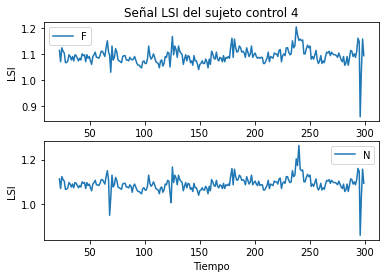

In [ ]:
#Se extraen los datos de todos los personas "CONTROL", se convierten a numpy y posteriormente se filtran.
CONTROL=[control]
c_fl=[]
c_fr=[]
L=[]
R=[]
t=[]
e=0
for ad in CONTROL:
  for archivo in CONTROL[e]:
    datos = pd.read_csv(archivo,sep='\t',names=names) #Se leen los archivos 
    #Se convierten los datos de 'Series' a numpy
    LSI_ = datos['LSI'].to_numpy() 
    RSI_=datos['RSI'].to_numpy()
    tiempo=datos['time'].to_numpy()
    #Se llama la función "hampel", que filtra las señales "LSI" y "RSI" de control.
    LSI=hampel(LSI_,5,3)
    c_fl.append(LSI)
    L.append(LSI_)
    RSI=hampel(RSI_,5,3)
    c_fr.append(RSI)
    R.append(RSI_)
    t.append(tiempo)
  e=e+1
DATA_FRAMEc=pd.DataFrame({'LSI':pd.Series(c_fl),'RSI':pd.Series(c_fr),'Tiempo':pd.Series(t)})

#Ejemplo de filtrado para el sujeto control 4.
plt.subplot(2,1,1)
plt.title('Señal LSI del sujeto control 4')
plt.plot(t[4],c_fl[4])
plt.ylabel('LSI')
plt.legend('F')
plt.subplot(2,1,2)
plt.plot(t[4],L[4])
plt.xlabel('Tiempo')
plt.ylabel('LSI')
plt.legend('NF')
plt.show()


**Rutina de fluctuaciones de magnitud**




A continuación se definen funciones para calcular los indices de fluctuación de magnitud que posteriormente serán de utilidad en el análisis de las señales procesadas.

1. Cálculo del coeficiente de variación

In [ ]:
#Se define una función que realiza el cálculo del coeficiente de la señal LSI.
def coef_varl(lsi):
  #Pie izquierdo
  DE1=np.std(lsi) #Calculo de la desviación estandar de la señal LSI.
  mean1=np.mean(lsi) #Cálculo de la media de la señal LSI.
  CV1=100*DE1/mean1 #Cálculo del coeficiente de variación. 
  return CV1

In [ ]:
#Se recrea la función anterior para la señal RSI.
def coef_varr(rsi):
  #Pie derecho
  DE2=np.std(rsi)
  mean2=np.mean(rsi)
  CV2=100*DE2/mean2
  return CV2

La definición de estas funciones entrega como resultado la relación entre el tamaño de la media y la variabilidad de los datos de la señal procesada.

2. Cálculo de la desviación estándar sin tendencia

In [ ]:
#Se define la función que realiza la desviación estándar sin tendencia para la señal LSI. 
def DS_tl(lsi,time):
  ds_t_l=np.diff(lsi,n=1) #Se deriva la señal LSI para obtener la señal sin tendencia.
  time_diff=time[0:ds_t_l.shape[0]] #Se limita el rango del tiempo hasta la longitud de la señal derivada. 
  dsl=np.std(ds_t_l) #Se calcula la desviación estándar sin tendencia de la señal derivada. 
  return dsl

In [ ]:
#Se recrea la función anterior para la señal RSI. 
def DS_tr(rsi,time):
  ds_t_r=np.diff(rsi,n=1)
  time_diff=time[0:ds_t_r.shape[0]]
  dsr=np.std(ds_t_r)
  return dsr

Determinar el valor de la desviación estandar sin tendencia, permite cuantificar la dispersión de los datos de la señal sin tener en cuenta la tendencia de los mismos.

**Rutinas de dinámica de la fluctuación**

A continuación se definen funciones para calcular los indices de dinámica de fluctuación que posteriormente serán de utilidad en el análisis de las señales procesadas.

1. Coeficiente de noestacionariedad

In [ ]:
#Se define la función para realizar el cálculo del coeficiente de noestacionariedad para la señal LSI.
def NSI_l(lsi):
  lsi_100=lsi[0:100] #Se toman los 100 primeros puntos de la señal.
  desv_lsi=np.std(lsi_100) #Se calcula la desviación estándar de los 100 primeros datos.
  media_lsi=np.mean(lsi_100) #Se calcula la media de los 100 primeros datos 
  norml=(lsi_100-media_lsi)/desv_lsi #Se normaliza la señal. 
  l=0
  prom_local_l=[]
  for t in range(0,20):
    x= norml[l:l+5] #Se divide la señal normalizada en 20 partes iguales.
    x1=np.mean(x) #Se calcula la media local
    prom_local_l.append(x1) 
    l=l+5 
  nsi_l=np.std(prom_local_l) #Se calcula la desviación estándar de los promedios locales. 
  return nsi_l
 

In [ ]:
#Se recrea la función anterior para la señal RSI.
def NSI_r(rsi):
  #Normalización derecha
  rsi_100=rsi[0:100]
  desv_rsi=np.std(rsi_100)
  media_rsi=np.mean(rsi_100)
  normr=(rsi_100-media_rsi)/desv_rsi
  
  m=0
  prom_local_r=[]
  for h in range(0,20):
    y= normr[m:m+5]#Se divide norml en 20 partes iguales
    y1=np.mean(y)
    prom_local_r.append(y1)
    m=m+5
  nsi_r=np.std(prom_local_r)
 
  return nsi_r

La determinación del coeficiente de no estacionariedad permite estimar como cambia el promedio local con el tiempo.

Para esto se tomaron los 100 primeros puntos de las señales con el fin de minimizar los efectos de las diferencias de un sujeto a otro en la longitud, la media o la varianza de los datos [1]. A demás la señal fue normalizada con respecto a su media y desviación estandar para ajustar los valores.

Para calcularla se tomaron 20 segmentos y a estos se le calcularon los promedios locales y para  estimar la dispersión de estas medias locales normalizadas se calculó la desviación estandar de los promedios locales.



In [ ]:
#Se define una función que calcula el coeficiente de inconsistencia de la varianza para la señal LSI.
def INC_l(lsi):
  lsi_100=lsi[0:100] #Se toman los 100 primero datos de la señal LSI.
  desv_lsi=np.std(lsi_100) #Se calcula la desviación estándar de los 100 primeros datos. 
  media_lsi=np.mean(lsi_100) #Se calcula el promedio de los 100 primeros datos.
  norml=(lsi_100-media_lsi)/desv_lsi # Se normaliza la señal.
  l=0
  desv_local_l=[]
  for t in range(0,20):
    x= norml[l:l+5] #Se divide la señal normalizada en 20 partes iguales.
    x2=np.std(x) #Se calcula la desviación estándar de la señal normalizada.
    desv_local_l.append(x2) 
    l=l+5 
  inc_vl=np.std(desv_local_l) #Se calcula la desviación estándar de las desviaciones locales.  
  return inc_vl

In [ ]:
#Se recrea la función anterior para la señal RSI.
def INC_r(rsi):
  rsi_100=rsi[0:100]
  desv_rsi=np.std(rsi_100)
  media_rsi=np.mean(rsi_100)
  normr=(rsi_100-media_rsi)/desv_rsi
  m=0
  desv_local_r=[]
  for h in range(0,20):
    y= normr[m:m+5]#Se divide norml en 20 partes iguales
    y2=np.std(y)
    desv_local_r.append(y2)
    m=m+5
  inc_vr=np.std(desv_local_r)
  return inc_vr

El cálculo de la inconsistencia de la varianza sirve para estimar la dispersión de la varianza local, la cual es independiente de la varianza general de los datos de la señal.

Para calcularla se tomaron 20 segmentos y a estos se le calcularon las desviaciones estandar local y para  estimar como cambiaba la desviación estandar local con el tiempo, se calculó la desviación estandar de estas.

# **Correspondencia entre la teoría y lo obtenido por los índices**

In [ ]:
#Función que permite una mejor visualización de los DataFrame
def displaydf(dataframe, cols = None, rows = None):
    with pd.option_context("display.max_columns", cols):
        with pd.option_context("display.max_rows", rows):
            display(dataframe)
    return True

**Prueba de las funciones para la aplicación de rutinas de fluctuación de magnitud y de dinámica de fluctuación**

In [ ]:
# Se extraen los datos de sujetos aleatorios para verificar el funcionamiento de las funciones definidas anteriormente.

#Extracción datos sujetos control 1
time_c1 = control1['time'].to_numpy()
LSI_c1 = control1['LSI'].to_numpy()
RSI_c1 = control1['RSI'].to_numpy()

#Extracción datos paciente 6 con ELA 
time_als6 = als6['time'].to_numpy()
LSI_als6 = als6['LSI'].to_numpy()
RSI_als6 = als6['RSI'].to_numpy()

#Extracción datos paciente 11 con Parkinson 
time_park11 = park11['time'].to_numpy()
LSI_park11 = park11['LSI'].to_numpy()
RSI_park11= park11['RSI'].to_numpy()

#Extracción datos paciente 10 con Huntington 
time_hunt10 = hunt10['time'].to_numpy()
LSI_hunt10 = hunt10['LSI'].to_numpy()
RSI_hunt10 = hunt10['RSI'].to_numpy()

#Ejemplo sujeto 1 control
c1lf=hampel(LSI_c1,5,3)
a=coef_varl(c1lf)
c1rf=hampel(RSI_c1,5,3)
b=coef_varr(c1rf)
c=DS_tl(c1lf,time_c1)
d=DS_tr(c1rf,time_c1)
f=NSI_l(c1lf)
g=NSI_r(c1rf)
h=INC_l(c1lf)
n=INC_r(c1rf)
CDATA=pd.DataFrame({'CV LSI':pd.Series(a),'CV RSI':pd.Series(b),'DEs LSI':pd.Series(c),'DEs RSI':pd.Series(d),'NSI LSI':pd.Series(f),'NSI RSI':pd.Series(g),'INC LSI':pd.Series(h),'INC RSI':pd.Series(n)})
print('Los índices para el sujeto 1 de control son:')
CDATA=displaydf(CDATA)
print(CDATA)

#Ejemplo paciente 6 con ELA 
als6lf=hampel(LSI_als6,5,3)
a=coef_varl(als6lf)
als6rf=hampel(RSI_als6,5,3)
b=coef_varr(als6rf)
c=DS_tl(als6lf,time_als6)
d=DS_tr(als6rf,time_als6)
f=NSI_l(als6lf)
g=NSI_r(als6rf)
h=INC_l(als6lf)
n=INC_r(als6rf)
ELADATA=pd.DataFrame({'CV LSI':pd.Series(a),'CV RSI':pd.Series(b),'DEs LSI':pd.Series(c),'DEs RSI':pd.Series(d),'NSI LSI':pd.Series(f),'NSI RSI':pd.Series(g),'INC LSI':pd.Series(h),'INC RSI':pd.Series(n)})
print('Los índices para el paciente 6 con ELA son:')
ELADATA=displaydf(ELADATA)
print(ELADATA)

#Ejemplo paciente 11 con Parkinson 
p11lf=hampel(LSI_park11,5,3)
a=coef_varl(p11lf)
p11rf=hampel(RSI_park11,5,3)
b=coef_varr(p11rf)
c=DS_tl(p11lf,time_park11)
d=DS_tr(p11rf,time_park11)
f=NSI_l(p11lf)
g=NSI_r(p11rf)
h=INC_l(p11lf)
n=INC_r(p11rf)
PDATA=pd.DataFrame({'CV LSI':pd.Series(a),'CV RSI':pd.Series(b),'DEs LSI':pd.Series(c),'DEs RSI':pd.Series(d),'NSI LSI':pd.Series(f),'NSI RSI':pd.Series(g),'INC LSI':pd.Series(h),'INC RSI':pd.Series(n)})
print('Los índices para el paciente 11 con Parkinson son:')
PDATA=displaydf(PDATA)
print(PDATA)

#Ejemplo paciente 10 con Huntington
h10lf=hampel(LSI_hunt10,5,3)
a=coef_varl(h10lf)
h10rf=hampel(RSI_hunt10,5,3)
b=coef_varr(h10rf)
c=DS_tl(h10lf,time_hunt10)
d=DS_tr(h10rf,time_hunt10)
f=NSI_l(h10lf)
g=NSI_r(h10rf)
h=INC_l(h10lf)
n=INC_r(h10rf)
HDATA=pd.DataFrame({'CV LSI':pd.Series(a),'CV RSI':pd.Series(b),'DEs LSI':pd.Series(c),'DEs RSI':pd.Series(d),'NSI LSI':pd.Series(f),'NSI RSI':pd.Series(g),'INC LSI':pd.Series(h),'INC RSI':pd.Series(n)})
print('Los índices para el paciente 10 con Huntington son:')
HDATA=displaydf(HDATA)
print(HDATA)


Los índices para el sujeto 1 de control son:


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
0,3.078522,3.005334,0.030629,0.027168,0.734829,0.739161,0.249996,0.268621


True
Los índices para el paciente 6 con ELA son:


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
0,6.418201,6.37319,0.100486,0.102024,0.688277,0.74935,0.390677,0.312611


True
Los índices para el paciente 11 con Parkinson son:


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
0,8.677115,8.425404,0.094987,0.054433,0.582213,0.876458,0.623265,0.307059


True
Los índices para el paciente 10 con Huntington son:


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
0,5.780825,4.889553,0.084611,0.07168,0.423192,0.491599,0.402114,0.248321


True


En la tabla mostrada anteriormente se observan los valores de los indices de fluctuación de magnitud y dinámica de fluctuación obtenidos para algunos sujetos elegidos de manera aleatoria, estos datos presentan relación con los valores de los indices, puesto que se encontraron valores lógicos evidenciado en la inexistencia de valores negativos, o de magnitudes muy grandes. 

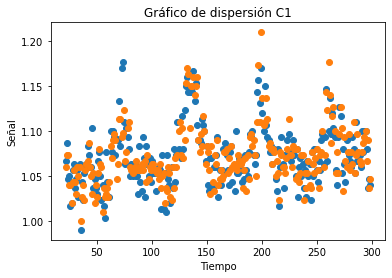

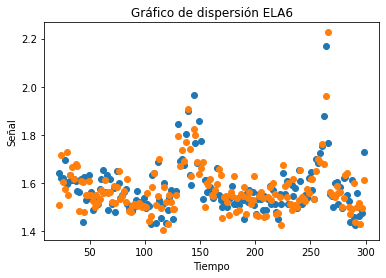

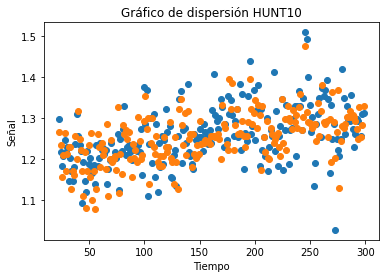

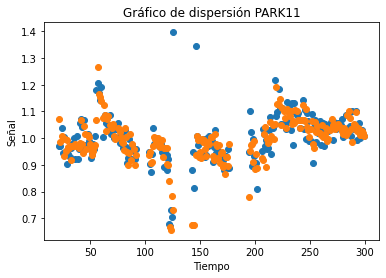

In [ ]:
# Gráficos de dispersión para control 1
fig, ax = plt.subplots()
ax.scatter(time_c1, c1lf )
ax.scatter(time_c1, c1rf)
plt.xlabel('Tiempo')
plt.ylabel('Señal')
plt.title('Gráfico de dispersión C1')
plt.show()

# Gráficos de dispersión para ELA 6
fig, ax = plt.subplots()
ax.scatter(time_als6, als6lf )
ax.scatter(time_als6, als6rf)
plt.xlabel('Tiempo')
plt.ylabel('Señal')
plt.title('Gráfico de dispersión ELA6')
plt.show()

# Gráficos de dispersión para HUNT 10
fig, ax = plt.subplots()
ax.scatter(time_hunt10, h10lf )
ax.scatter(time_hunt10, h10rf)
plt.xlabel('Tiempo')
plt.ylabel('Señal')
plt.title('Gráfico de dispersión HUNT10')
plt.show()

# Gráficos de dispersión para PARK 11
fig,ax = plt.subplots()
ax.scatter(time_park11, p11lf )
ax.scatter(time_park11, p11rf)
plt.xlabel('Tiempo')
plt.ylabel('Señal')
plt.title('Gráfico de dispersión PARK11')
plt.show()

Al comparar los resultados obtenidos para los índices de fluctuación de magnitud y dinámica de fluctuación de las señales y los gráficos de dispersión presentados se encuentra que este los índices mantienen una relación directa con los datos, pues a medida que se observa una mayor variabilidad en la gráfica también se observa una correspondencia con los valores calculados del coeficiente de variación, desviación estandar sin tendencia, coeficiente de noestacionariedad e inconsistencia de la varianza, pues estos también aumentan, siendo control el sujeto con menor variabilidad en sus datos en comparación de los demás sujetos de estudio, lo cual era de esperarse al tratarse de un sujeto de referencia.

**Procesamiento y extracción de las características de las señales**


In [ ]:
names = ['time','LSI','RSI','LSwI','RSwI','LSIp','RSIp','LStI','RStI','LStIp','RStIp','DSI','DSIp']
import glob #Se importa la libreria 'glob'.
control = glob.glob('/content/senales/control*ts') #Se cargan los archivos correspondientes a los pacientes control.
als = glob.glob('/content/senales/als*ts') #Se cargan los archivos correspondientes a los pacientes con ELA.
hunt = glob.glob('/content/senales/hunt*ts') #Se cargan los archivos correspondientes a los pacientes con enfermedad de Huntington.
park = glob.glob('/content/senales/park*ts') #Se cargan los archivos correspondientes a los pacientes con Parkinson.

In [ ]:
#Se crean listas vacías para almacenar información 
c_varl=[]
c_varr=[]
desv_stl=[]
desv_str=[]
nsi_l=[]
nsi_r=[]
inc_l=[]
inc_r=[]
ARCHIVOS=[control,als,hunt,park]
e=0
for A in ARCHIVOS:
  for archivo in ARCHIVOS[e]:
    datos = pd.read_csv(archivo,sep='\t',names=names) #Se leen los archivos 
    #Se convierten los datos de 'Series' a numpy
    LSI = datos['LSI'].to_numpy() 
    RSI=datos['RSI'].to_numpy()
    tiempo=datos['time'].to_numpy()
    LSI_F=hampel(LSI,5,3)
    RSI_F=hampel(RSI,5,3)
  #Rutina de fluctuacion de magnitud
    #Coeficiente de variación 
    c_var_l= coef_varl(LSI_F) #Se llama la función definida anteriormente
    c_varl.append(c_var_l) 
    c_var_r= coef_varr(RSI_F) #Se llama la función definida anteriormente
    c_varr.append(c_var_r)
    #Desviación estándar sin tendencia
    desv_st_l=DS_tl(LSI_F,tiempo) #Se llama la función definida anteriormente
    desv_stl.append(desv_st_l)
    desv_st_r=DS_tr(RSI_F,tiempo) #Se llama la función definida anteriormente
    desv_str.append(desv_st_r)
  #Rutina de dinámica de la fluctuación 
    #Coeficiente de noestacionariedad normalizado
    nl=NSI_l(LSI_F) #Se llama la función definida anteriormente
    nsi_l.append(nl)
    nr=NSI_r(RSI_F) #Se llama la función definida anteriormente
    nsi_r.append(nr)
    #Indice de inconsistencia de varianza
    nil=INC_l(LSI_F) #Se llama la función definida anteriormente
    inc_l.append(nil)
    nir=INC_r(RSI_F) #Se llama la función definida anteriormente
    inc_r.append(nir)
  e=e+1
#Se crea el DataFrame que recopila la información de los indices
Data=pd.DataFrame({'CV LSI':pd.Series(c_varl),'CV RSI':pd.Series(c_varr),'DEs LSI':pd.Series(desv_stl),'DEs RSI':pd.Series(desv_str),'NSI LSI':pd.Series(nsi_l),'NSI RSI':pd.Series(nsi_r),'INC LSI':pd.Series(inc_l),'INC RSI':pd.Series(inc_r)})
#Data=displaydf(Data)
CONTROL=Data[0:16]
print("PACIENTES CONTROL")
print(displaydf(CONTROL))
ELA=Data[16:29]
print("PACIENTES ELA")
print(displaydf(ELA))
HUNT=Data[29:49]
print("PACIENTES HUNT")
print(displaydf(HUNT))
PARK=Data[49:64]
print("PACIENTES PARKINSON")
print(displaydf(PARK))

PACIENTES CONTROL


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
0,2.598469,2.474653,0.025961,0.023558,0.760192,0.800159,0.357727,0.242144
1,3.571907,3.625486,0.041753,0.038091,0.761891,0.764414,0.440403,0.357463
2,2.511290,3.375128,0.027195,0.039242,0.660208,0.717646,0.393782,0.441924
3,2.853284,2.826821,0.026791,0.028246,0.771674,0.746828,0.253734,0.281847
4,2.697244,3.135081,0.032747,0.043973,0.675625,0.531975,0.378214,0.631577
5,3.025561,3.104065,0.036851,0.032717,0.755372,0.774204,0.354823,0.359954
6,2.816533,2.834757,0.025200,0.029272,0.656526,0.584084,0.338145,0.310360
7,2.998492,3.084773,0.024860,0.029203,0.770174,0.705778,0.339905,0.363333
8,3.239424,3.149967,0.035638,0.035531,0.632052,0.533665,0.335352,0.297883
9,3.914170,4.131660,0.041970,0.051697,0.593880,0.502537,0.471708,0.443848


True
PACIENTES ELA


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
16,6.036516,5.899160,0.086468,0.087196,0.792260,0.756585,0.302064,0.280779
17,6.583353,5.819014,0.088216,0.069611,0.596950,0.588476,0.286888,0.403610
18,4.024492,4.094174,0.041060,0.046091,0.806683,0.723240,0.359908,0.525135
19,2.785780,2.695571,0.033470,0.031947,0.767285,0.765631,0.305203,0.311261
20,6.394923,6.775903,0.065466,0.065892,0.762637,0.809167,0.250476,0.274413
21,6.026137,5.885108,0.049205,0.044088,0.907326,0.894996,0.137691,0.231563
22,10.944433,9.344063,0.182284,0.178108,0.409978,0.541021,0.712754,0.515544
23,2.459976,2.524153,0.030693,0.030069,0.714687,0.705613,0.291932,0.277431
24,6.418201,6.373190,0.100486,0.102024,0.688277,0.749350,0.390677,0.312611
25,1.805344,1.660907,0.029428,0.024976,0.392264,0.415019,0.293636,0.405977


True
PACIENTES HUNT


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
29,8.093086,7.557664,0.110381,0.113728,0.582551,0.446623,0.319885,0.418788
30,4.066793,3.797438,0.035444,0.036451,0.656388,0.733256,0.360655,0.296909
31,5.789153,5.376414,0.076023,0.073511,0.778838,0.688520,0.355619,0.349704
32,5.780825,4.889553,0.084611,0.071680,0.423192,0.491599,0.402114,0.248321
33,18.575737,17.836839,0.266605,0.261751,0.458887,0.360946,0.408357,0.458620
34,4.795704,6.227784,0.046274,0.065563,0.658301,0.637245,0.460601,0.541344
35,9.273374,8.993891,0.130408,0.131246,0.565310,0.659746,0.427168,0.284443
36,3.685827,3.326922,0.031883,0.031004,0.776566,0.815999,0.324288,0.260500
37,6.820665,6.718683,0.100970,0.101028,0.595251,0.646190,0.356329,0.345991
38,4.169317,4.250615,0.062202,0.064445,0.356448,0.478643,0.510456,0.448418


True
PACIENTES PARKINSON


,CV LSI,CV RSI,DEs LSI,DEs RSI,NSI LSI,NSI RSI,INC LSI,INC RSI
49,3.216347,3.263537,0.040019,0.037523,0.808185,0.834554,0.246733,0.186075
50,4.310220,3.772645,0.042463,0.039765,0.685093,0.665026,0.343559,0.301574
51,12.756536,17.220916,0.059773,0.143144,0.939919,0.802437,0.146167,0.499858
52,9.150581,9.490753,0.160589,0.154956,0.572901,0.541567,0.527130,0.538954
53,3.857103,3.757114,0.055417,0.054308,0.495027,0.474189,0.537416,0.338862
54,8.677115,8.425404,0.094987,0.054433,0.582213,0.876458,0.623265,0.307059
55,3.587002,3.762057,0.047432,0.049504,0.488475,0.606083,0.332423,0.312830
56,5.516874,5.055218,0.035466,0.029024,0.806664,0.796708,0.372991,0.378312
57,5.277804,5.446001,0.071921,0.073070,0.753812,0.643230,0.359763,0.487474
58,5.974005,7.000150,0.060773,0.082027,0.731720,0.682442,0.492400,0.499409


True


## **Comparación de los índices entre sujetos Control, ELA y Parkinson**

Para el análisis estadístico de los datos se hace uso de pruebas no paramétricas puesto que a estos datos no se les realizaron pruebas para comprobar si seguian o no una distribución normal. Por lo que las pruebas no paramétricas son de gran utilidad en estos casos, debido a que no hacen suposiciones sobre la distribución subyacente de los datos.

Una vez decidido el tipo de pruebas a realizar, en este caso no paramétricas, se implementa el test de U de Mann-Whitney, el cual permite comparar las diferencias entre dos muestras cuando los tamaños de las muestras son pequeños (n < 30). Adicionalmente, el valor del nivel de significancia a tomar será de 0.05.



### **Pruebas de hipótesis**

Para realizar las pruebas de hipótesis, se tomaron en cuenta solo los índices para la pierna de derecha de los sujetos a analizar. 

H 0 :  El Coeficiente de variación del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con ELA.

H A :  El Coeficiente de variación del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con ELA.

In [ ]:
import scipy.stats as stats #Se importa la libreria scipy que contiene herramientas estadísticas.
u_statistic, pVal = stats.mannwhitneyu(c_varr[0:16] , c_varr[16:29]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)


Valor P: 0.003498853012357593


*  Dado que el valor p ( 0.003498) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre los coeficientes de variación del intervalo de zancada derecha de los sujetos control y los pacientes con ELA.


H 0 :  El Coeficiente de variación del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con Parkinson.

H A :  El Coeficiente de variación del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(c_varr[0:16] , c_varr[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.00010954942300446618


* Dado que el valor p ( 0.0001095) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre los coeficientes de variación del intervalo de zancada derecha de los sujetos control y los pacientes con Parkinson.

H 0 :  El Coeficiente de variación del intervalo de zancada derecha es igual entre los pacientes con ELA y con Parkinson.

H A :  El Coeficiente de variación del intervalo de zancada derecha no es igual entre los pacientes con ELA y con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(c_varr[16:29] , c_varr[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.5


* Dado que el valor p ( 0.5 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los coeficientes de variación del intervalo de zancada derecha de los pacientes con ELA y con Parkinson.

H 0 :  El Coeficiente de no estacionariedad del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con ELA.

H A :  El Coeficiente de no estacionariedad del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con ELA.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(nsi_r[0:16] , nsi_r[16:29]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.13173033641745124


* Dado que el valor p ( 0.1317 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los coeficientes de noestacionariedad del intervalo de zancada derecha de los sujetos control y los pacientes con ELA.

H 0 : El Coeficiente de no estacionariedad del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con Parkinson.

H A : El Coeficiente de no estacionariedad del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(nsi_r[0:16] , nsi_r[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.41394574830731296


* Dado que el valor p ( 0.4139 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los coeficientes de noestacionariedad del intervalo de zancada derecha de los sujetos control y los pacientes con Parkinson.

H 0 : El Coeficiente de no estacionariedad del intervalo de zancada derecha es igual entre los los pacientes con ELA y con Parkinson.

H A : El Coeficiente de no estacionariedad del intervalo de zancada derecha no es igual entre los pacientes con ELA y con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(nsi_r[16:29] , nsi_r[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.20350235756514268


* Dado que el valor p ( 0.2035 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los coeficientes de noestacionariedad del intervalo de zancada derecha de los pacientes con ELA y con Parkinson.

H 0 : La desviación estandar sin tendencia del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con ELA.

H A : La desviación estandar sin tendencia  del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con ELA.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(desv_stl[0:16] , desv_stl[16:29]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.00017577678728790711


* Dado que el valor p ( 0.000175) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre las desviaciones estandar sin tendencia del intervalo de zancada derecha de los sujetos control y los pacientes con ELA.

H 0 : La desviación estandar sin tendencia del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con Parkinson.

H A : La desviación estandar sin tendencia  del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(desv_stl[0:16] , desv_stl[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 1.521303903189396e-05


* Dado que el valor p ( 1.5213e-05 ) es menor que 0.05, se rechaza la hipótesis nula, lo que significa que existe una diferencia entre las desviaciones estandar sin tendencia del intervalo de zancada derecha de los sujetos control y los pacientes con Parkinson.

H 0 : La desviación estandar sin tendencia del intervalo de zancada derecha es igual entre los pacientes con ELA y con Parkinson.

H A : La desviación estandar sin tendencia  del intervalo de zancada derecha no es igual entre los pacientes con ELA y con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(desv_stl[16:29] , desv_stl[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.2746366343880404


* Dado que el valor p ( 0.27463 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre las desviaciones estandar sin tendencia del intervalo de zancada derecha de los pacientes con ELA y con Parkinson.

H 0 : El índice de incosistencia de la varianza del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con ELA.

H A : El índice de inconsistencia de la varianza del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con ELA.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(inc_r[0:16] , inc_r[16:29]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.3384845685743053


* Dado que el valor p ( 0.3384 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los índices de inconsistencia de la varianza del intervalo de zancada derecha de los sujetos control y los pacientes con ELA.

H 0 : El índice de incosistencia de la varianza del intervalo de zancada derecha es igual entre los sujetos control y los pacientes con Parkinson.

H A : El índice de inconsistencia de la varianza del intervalo de zancada derecha no es igual entre los sujetos control y los pacientes con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(inc_r[0:16] , inc_r[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.17646551653810827


* Dado que el valor p ( 0.1764 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los índices de inconsistencia de la varianza del intervalo de zancada derecha de los sujetos control y los pacientes con Parkinson.

H 0 : El índice de incosistencia de la varianza del intervalo de zancada derecha es igual entre los pacientes con ELA y con Parkinson.

H A : El índice de inconsistencia de la varianza del intervalo de zancada derecha no es igual entre los pacientes con ELA y con Parkinson.

In [ ]:
u_statistic, pVal = stats.mannwhitneyu(inc_r[16:29] , inc_r[49:64]) #Se aplica el test de Mann-Whitney
print ('Valor P:', pVal)

Valor P: 0.12473583425552626


* Dado que el valor p ( 0.1247 ) no es menor que 0.05, no se rechaza la hipótesis nula. No se tiene evidencia suficiente para decir que no existe una diferencia entre los índices de inconsistencia de la varianza del intervalo de zancada derecha de los pacientes con ELA y con parkinson.

## **Análisis de resultados**

Debido a que en este proyecto se evalúan la señales mediante herramientas de la estadística es posible encontrar que en cada grupo de sujetos estudiados los indices de fluctuación de magnitud y dinámica de fluctuación varían notoriamente. Se observa por ejemplo, que para el caso del coeficiente de variación para LSI y RSI varían entre 1.3 y 4.1 en sujetos control, mientras que para los pacientes que presentan ELA, Parkinson o Huntington el intervalo de esta variable es mucho mayor; el aumento en esta medida estadística es razonable debido a que el coeficiente de variación mide la fluctuación de la velocidad de la caminata, pues da información acerca de la variabilidad del tiempo de balanceo con respecto a un valor promedio de duración de cada paso. En este orden de ideas se puede decir que estos valores se ven influenciados por factores como la fuerza del balanceo, el estado funcional y la salud mental del sujeto [2].

Por otra parte, en las pruebas de hipótesis realizadas se encontró que el coeficiente de variación es un indice válido que revela información acerca de las diferencias de la marcha entre sujetos sanos y con alteraciones motoras, sin embargo, a partir de este índice no es posible diferenciar entre sujetos con enfermedades neurodegenerativas, por lo tanto, se hace necesario implementar otros indices para distinguir las variaciones de la marcha entre pacientes enfermos. 

Así mismo, gracias al análisis estadístico realizado, se determinó que la desviación estándar sin tendencia, también es un parámetro que sirve para diferenciar la marcha entre sujetos control y aquellos que padecen algún tipo de enfermedad, ya que el valor p resultante es menor que el nivel de significancia elegido. Análogamente al anterior índice, este parámetro no es significativo entre pacientes con ELA y Parkinson. 

En cuanto a los índices de dinámica de fluctuación se encontró que no es posible rechazar la hipótesis nula establecida puesto que el valor p en los dos casos excede el nivel de significancia establecido de 0.05, lo que da cuenta, de que no es posible hacer una diferenciación entre los grupos estudiados. Por lo tanto, para estudios futuros será necesario evaluar la aplicación de nuevos índices. 

En este sentido, el estudio de las señales a nivel clínico es de gran importancia porque con ellas se puede representar variables fisiológicas que presentan múltiples comportamientos como la presión, la temperatura y demás. Estudiar las señales de marcha humana es de gran utilidad debido a que con este tipo de investigaciones es posible realizar diagnósticos y hacer una adecuada elección de tratamientos en pacientes con enfermedades neurodegenerativas en donde se ve afectado el control motor como por ejemplo, la forma de caminar. Sin embargo, si se requiere de un estudio más especializado es fundamental tener cuenta otras variables que caractericen el estado de la marcha de los sujetos de estudio. 




## **Referencias**

[1] J. M. Ramírez, F. Moreno, and R. Medina, “Análisis de la serie temporal del balanceo en la marcha de pacientes con parkinson.” [En línea]. Disponible en: http://ve.scielo.org/scielo.php?script=sci_arttext&pid=S1316-48212006000400004.

[2] J. M. Hausdorff et al., “Marcadores dinámicos de ritmo de marcha alterado en la esclerosis lateral amiotrófica,” pp. 2045–2053, 2018.